In [17]:
import shutil
from functools import reduce

import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession

from kaggle_pfs.data import readers

sns.set_theme(style='white')


In [2]:
spark = SparkSession.builder.appName("Predict Future Sales").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/02 13:24:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sales_train = (
    spark.read.options(header=True, dateFormat="dd.MM.yyyy")
    .schema("date DATE, date_block_num INT, shop_id INT, item_id INT, item_price DOUBLE, item_cnt_day DOUBLE")
    .csv(readers.data_path("raw", "sales_train.csv"))
)
sales_train.createOrReplaceTempView("sales_train")


In [4]:
test_set = (
    spark.read.options(header=True)
    .schema("ID INT, shop_id INT, item_id INT")
    .csv(readers.data_path("raw", "test.csv"))
)
test_set.createOrReplaceTempView("test_set")


In [5]:
spark.sql("select count(distinct shop_id, item_id), count(*) as total from sales_train").show()


+--------------------------------+-------+
|count(DISTINCT shop_id, item_id)|  total|
+--------------------------------+-------+
|                          424124|2935849|
+--------------------------------+-------+



In [6]:
spark.sql("select count(distinct shop_id,  item_id), count(*) as total from test_set").show()


+--------------------------------+------+
|count(DISTINCT shop_id, item_id)| total|
+--------------------------------+------+
|                          214200|214200|
+--------------------------------+------+



Let's get monthly item_cnt. group by month, shop, item


In [7]:
yearmon_sales = spark.sql(
    """
select date_trunc('MM', `date`) as yearmon, date_block_num, shop_id, item_id, sum(item_cnt_day) as item_cnt
from sales_train
group by yearmon, date_block_num, shop_id, item_id
"""
).cache()
yearmon_sales.createOrReplaceTempView("yearmon_sales")


In [8]:
yearmon_sales.select("item_cnt").summary().show()


+-------+-----------------+
|summary|         item_cnt|
+-------+-----------------+
|  count|          1609124|
|   mean|2.267200041761853|
| stddev|8.649881798050128|
|    min|            -22.0|
|    25%|              1.0|
|    50%|              1.0|
|    75%|              2.0|
|    max|           2253.0|
+-------+-----------------+



Let's see some indicators for the `ID`'s in the `test.csv` and what kind of train data
we have for them.

In [9]:
summary_test = spark.sql(
    """
select t.ID, t.shop_id, t.item_id, s.n_months, s.item_cnt, s.first_sold, s.last_sold
from test_set t
left join (
    select shop_id, item_id, count(*) as n_months, sum(item_cnt) as item_cnt, min(yearmon) as first_sold, max(yearmon) as last_sold
    from yearmon_sales
    group by shop_id, item_id
) s on s.shop_id = t.shop_id and s.item_id = t.item_id
"""
).cache()
summary_test.createOrReplaceTempView("summary_test")


There are 4 pairs of $\left(shop\_id, item\_id \right)$ with total quantity sold higher than 10k units

In [10]:
spark.sql("select * from summary_test order by item_cnt desc").show()


+------+-------+-------+--------+--------+-------------------+-------------------+
|    ID|shop_id|item_id|n_months|item_cnt|         first_sold|          last_sold|
+------+-------+-------+--------+--------+-------------------+-------------------+
| 46360|     31|  20949|      30| 19934.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 56560|     25|  20949|      29| 14343.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 41260|     28|  20949|      31| 13458.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
|102460|     42|  20949|      30| 10514.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 37296|     12|  11373|      34|  6563.0|2013-01-01 00:00:00|2015-10-01 00:00:00|
| 37341|     12|  11370|      34|  6163.0|2013-01-01 00:00:00|2015-10-01 00:00:00|
|138160|     57|  20949|      29|  6116.0|2013-05-01 00:00:00|2015-10-01 00:00:00|
|127960|     47|  20949|      26|  4530.0|2013-05-01 00:00:00|2015-10-01 00:00:00|
| 61660|     22|  20949|      31|  4382.0|2013-04-01 00:00:00|2015-10-01 00:00:00|
| 71

In [11]:
spark.sql(
    """
select if(item_cnt is null, "null", "not null") as is_null, count(*) as n
from summary_test
group by is_null
"""
).show()


+--------+------+
| is_null|     n|
+--------+------+
|not null|111404|
|    null|102796|
+--------+------+



How many $\left(shop\_id, item\_id \right)$ were sold last for past 12 months

In [12]:
spark.sql(
    """
select last_sold, count(*)
from  summary_test
where item_cnt is not null
group by last_sold
order by last_sold desc
"""
).show(n=12)


+-------------------+--------+
|          last_sold|count(1)|
+-------------------+--------+
|2015-10-01 00:00:00|   28680|
|2015-09-01 00:00:00|   15078|
|2015-08-01 00:00:00|   12187|
|2015-07-01 00:00:00|    8391|
|2015-06-01 00:00:00|    5629|
|2015-05-01 00:00:00|    4528|
|2015-04-01 00:00:00|    3916|
|2015-03-01 00:00:00|    4120|
|2015-02-01 00:00:00|    3295|
|2015-01-01 00:00:00|    3196|
|2014-12-01 00:00:00|    3816|
|2014-11-01 00:00:00|    1877|
+-------------------+--------+
only showing top 12 rows



For each $\left(shop\_id, item\_id \right)$, how many months of observations do we have?

<AxesSubplot:xlabel='n_months', ylabel='p'>

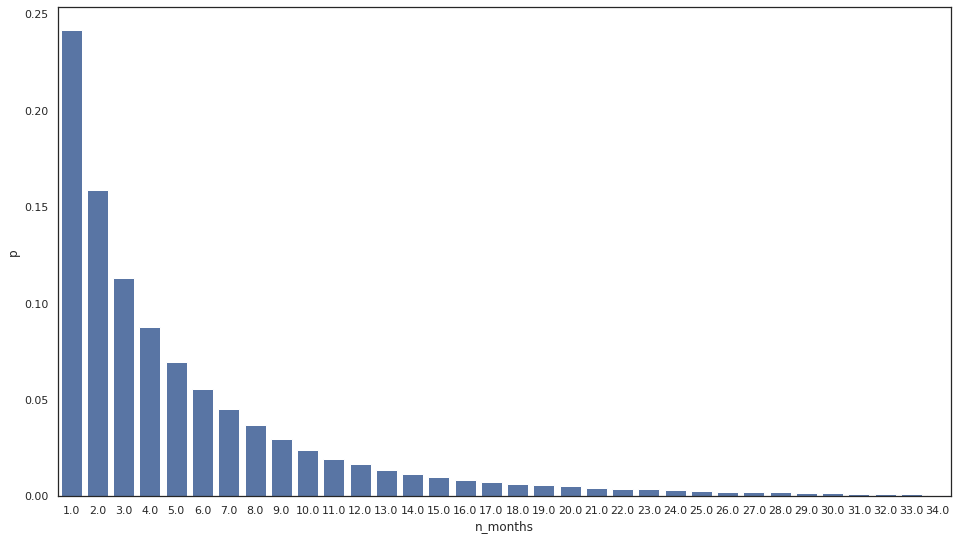

In [19]:
df = spark.sql(
    """
select n_months, count(*) / (select count_if(isnotnull(item_cnt)) from summary_test) as p
from summary_test
group by n_months
"""
).toPandas()

fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(data=df, x="n_months", y="p", color=sns.color_palette()[0], ax=ax)


In [14]:
def plot_item_cnt(df: pd.DataFrame, *, size=None, dpi=96):
    if size is None:
        size = (16, 9)
    x_px, y_px = [dpi * i for i in size]
    x_range = (df.date_block_num.min(), df.date_block_num.max())
    y_range = (df.item_cnt.min(), df.item_cnt.max())

    cvs = ds.Canvas(plot_width=x_px, plot_height=y_px, x_range=x_range, y_range=y_range)
    aggs = (cvs.line(df.loc[[i]], "date_block_num", "item_cnt", line_width=1) for i in df.index.unique())
    shades = (tf.shade(agg, cmap=cc.glasbey[i % len(cc.glasbey)]) for i, agg in enumerate(aggs))
    img = reduce(tf.stack, shades)

    fig, ax = plt.subplots(figsize=size)  # type: plt.Figure, plt.Axes
    ax.imshow(img.to_pil(), aspect='auto', extent=(*x_range, *y_range))
    ax.grid(visible=False)

    return fig, ax


(<Figure size 1152x648 with 1 Axes>, <AxesSubplot:>)

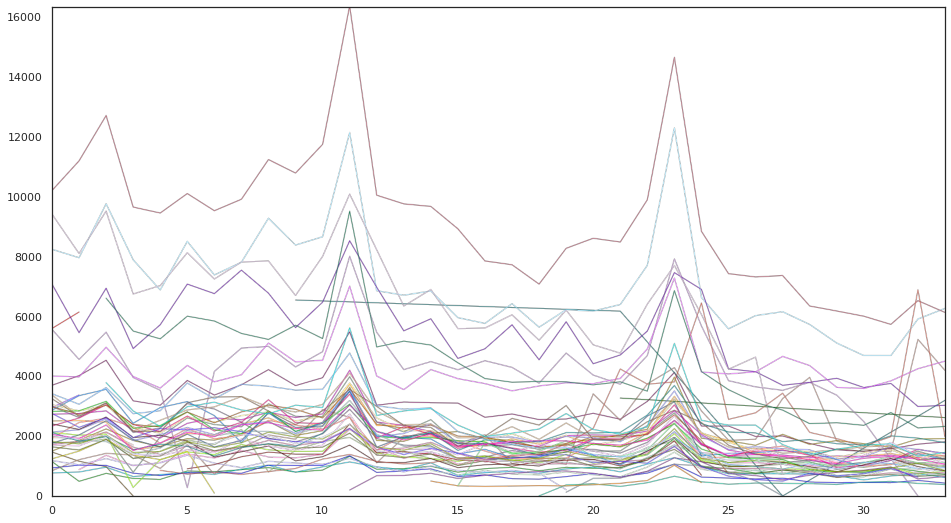

In [20]:
df = (
    spark.sql(
        f"""
    select shop_id, date_block_num, sum(item_cnt) as item_cnt
    from yearmon_sales
    group by shop_id, date_block_num
    order by shop_id, date_block_num
    """
    )
    .toPandas()
    .set_index("shop_id")
)

plot_item_cnt(df)

(<Figure size 1152x648 with 1 Axes>, <AxesSubplot:>)

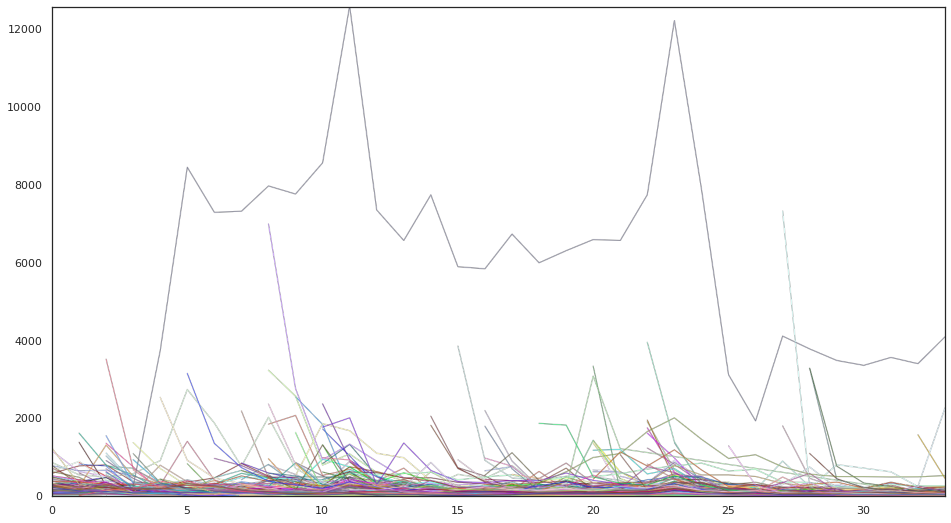

In [21]:
df = (
    spark.sql(
        f"""
    select ys.item_id, ys.date_block_num, sum(ys.item_cnt) as item_cnt
    from yearmon_sales ys
    right join (
      select item_id, sum(item_cnt) as item_cnt
      from yearmon_sales
      group by item_id
      order by item_cnt desc
      limit 256
    ) ts on ts.item_id = ys.item_id
    group by ys.item_id, ys.date_block_num
    order by ys.item_id, ys.date_block_num
    """
    )
    .toPandas()
    .set_index('item_id')
)

plot_item_cnt(df)

(<Figure size 1152x648 with 1 Axes>, <AxesSubplot:>)

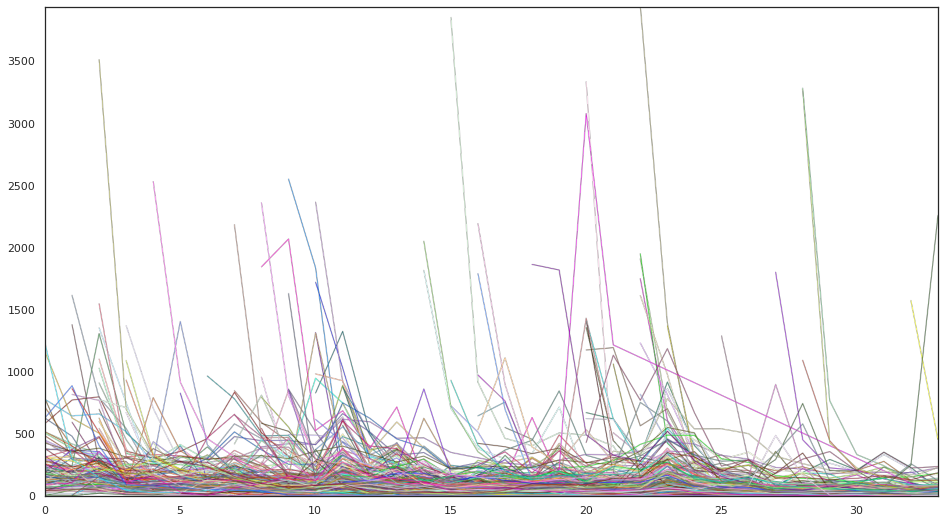

In [22]:
item_exclusion = (
    df.groupby("item_id")[["item_cnt"]]
    .sum()
    .sort_values(by="item_cnt", ascending=False)
    .head(n=10)
    .index.to_list()
)

plot_item_cnt(df.loc[~df.index.isin(item_exclusion)])

In [75]:
out_folder = readers.data_path("processed", "items_by_month.orc")
shutil.rmtree(out_folder, ignore_errors=True)

(
    yearmon_sales.groupBy(["shop_id", "item_id"])
    .pivot("date_block_num")
    .sum("item_cnt")
    .fillna(0)
    .write.orc(out_folder)
)
